In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import pandas as pd
from ai4neb import manage_RM
%matplotlib inline
import matplotlib as mpl
mpl.rc('image', cmap='jet')
dir_RMs = 'RMs/'
dir_CSVs = 'CSVs/'

### Download the HII region photoionization models from 3MdB. If already stored on disk, only read them

In [2]:
def get_data_17(datafile='data_BOND_17.csv', force=False):
    if not os.path.exists(dir_CSVs + datafile) or force:
        sel = """SELECT
                log10(O__3_500684A/H__1_486133A) as O3,  
                log10(N__2_658345A/H__1_486133A) as N2, 
                log10(BLND_372700A/H__1_486133A) as O2, 
                log10((NE_3_386876A + NE_3_396747A)/H__1_486133A) as Ne3,
                log10(AR_3_713579A/H__1_486133A) as Ar3,
                log10(HE_1_587564A/H__1_486133A) as He1,
                log10(BLND_436300A/O__3_500684A) as rO3,
                log10(BLND_575500A/N__2_658345A) as rN2,
                NITROGEN - OXYGEN as NO,
                OXYGEN as O,
                logU_mean as logU,
                SUBSTRING(com2, 5) as fr,
                SUBSTRING(com3, 6) as age,
                HbFrac
                FROM tab_17 
                WHERE ref = 'BOND_2' """
        db = pymysql.connect(host=os.environ['MdB_HOST'], 
                                user=os.environ['MdB_USER'], 
                                passwd=os.environ['MdB_PASSWD'], 
                                db=os.environ['MdB_DB_17'])    
        res = pd.read_sql(sel, con=db)
        res.fr = res.fr.astype('float64') 
        res.age = res.age.astype('float64')/1e6
        db.close()
        res.to_csv(dir_CSVs + datafile)
    else:
        res = pd.read_csv(dir_CSVs + datafile)
    return res
res = get_data_17(force=False)
print('Total number of models:', len(res))

Total number of models: 210600


In [3]:
print(os.environ['MdB_HOST'], 
                                os.environ['MdB_USER'], 
                                os.environ['MdB_PASSWD'], 
                                os.environ['MdB_DB_17'])

3mdb.astro.unam.mx OVN_user oiii5007 3MdB_17


In [3]:
np.unique(res.age)

array([1., 2., 3., 4., 5., 6.])

## Define the parameters used in the training process. Inputs as X, outputs as y.

In [4]:
X_keys = ['O', 'NO', 'logU', 'fr', 'age', 'HbFrac']
y_keys = ['O3', 'N2', 'O2', 'Ne3', 'Ar3', 'He1', 'rO3', 'rN2']
X_train = np.array(res[X_keys])
y_train = np.array(res[y_keys])

In [5]:
X_dic = {k:i for i,k in enumerate(X_keys)}
y_dic = {k:i for i,k in enumerate(y_keys)}
print(X_dic)
print(y_dic)

{'O': 0, 'NO': 1, 'logU': 2, 'fr': 3, 'age': 4, 'HbFrac': 5}
{'O3': 0, 'N2': 1, 'O2': 2, 'Ne3': 3, 'Ar3': 4, 'He1': 5, 'rO3': 6, 'rN2': 7}


## Train the neuronal network (takes a few minutes). If already trained, just load it from disk

In [10]:
def make_RM(type_='ANN', force=False, **kwargs):
    if not force:
        RM = manage_RM(RM_filename=dir_RMs + 'Forward_ML_{}'.format(type_))
        if not RM.model_read:
            force = True
    if force:
        if type_ in ('XGB', 'K_ANN'):
            RM_type = type_
        else:
            RM_type = 'SK_{}'.format(type_)
        RM = manage_RM(RM_type = RM_type, X_train=X_train, y_train=y_train, verbose=True, scaling=True, split_ratio=0.2)
        RM.init_RM(**kwargs)
        RM.train_RM()
        RM.save_RM(dir_RMs + 'Forward_ML_{}'.format(type_), save_test=True, save_train=True)   
    print('{}: Trained with {} models in {:.2f}s, tested with {} models. Score: {}'.format(type_, 
                                                                                           RM.N_train, 
                                                                                           RM.training_time, 
                                                                                           RM.N_test,
                                                                                           RM.train_score))
    return(RM)

In [ ]:
RM_SVM = make_RM(type_='SVM', tol=1e-3, epsilon=0.1, C=1.0)

No ai4neb file found for RMs/Forward_ML_SVM
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 168480, Test set size = 42120
Train data scaled. 
Test data scaled. 
Training set size = 168480, Test set size = 42120
Training set size = 168480, Test set size = 42120
Regression Model SK_SVM
Training 6 inputs for 8 outputs with 168480 data


In [8]:
RM_XGB = make_RM(type_='XGB', learning_rate=.001, n_estimators=5000, max_depth=30) # needs xgboost to be installed. Save/restore fails.

XGB: Trained with 42120 models in 4092.59s, tested with 168480 models. Score: [0.9996883141419473, 0.9994024459317074, 0.9995688757823784, 0.9995930781935319, 0.9981504536001838, 0.9977113076409733, 0.9983777133658166, 0.9983077649995837]


In [9]:
RM_ANN = make_RM(type_= 'ANN', max_iter=20000, tol=1e-8, solver='lbfgs', activation='tanh', 
                hidden_layer_sizes=(50, 50, 50))

ANN: Trained with 168480 models in 5914.46s, tested with 42120 models. Score: [0.9992782954278735]


In [14]:
RM_ANN = make_RM(type_= 'ANN', max_iter=20000, tol=1e-8, solver='lbfgs', activation='tanh', 
                hidden_layer_sizes=(50, 50, 50))
print('-------------------')
RM_KANN = make_RM(type_= 'K_ANN', max_iter=20000, tol=1e-8, activation='tanh', 
                hidden_layer_sizes=(50, 50, 50))
print('-------------------')
RM_SVM = make_RM(type_='SVM')
print('-------------------')
RM_AB = make_RM(type_='AB', force=True) #, n_estimators=1500, learning_rate=0.1)
print('-------------------')
RM_BR = make_RM(type_='BR')
print('-------------------')
RM_GBR = make_RM(type_='GBR', n_estimators=1500, learning_rate=0.01)
print('-------------------')
#RM_GPR = make_RM(type_='GPR') # very memory consuming (20Go!)
#print('-------------------')
RM_RFR = make_RM(type_='RFR')
print('-------------------')
RM_SGDR = make_RM(type_='SGDR')
print('-------------------')
RM_XGB = make_RM(type_='XGB', learning_rate=.1, n_estimators=500, max_depth=10) # needs xgboost to be installed. Save/restore fails, but takes 20 secs to train.

ANN: Trained with 168480 models in 5914.46s, tested with 42120 models. Score: [0.9992782954278735]
-------------------
K_ANN: Trained with 42120 models in 182.58s, tested with 168480 models. Score: [0.9970805816832791]
-------------------
SVM: Trained with 42120 models in 261.63s, tested with 168480 models. Score: [0.9452000213396851, 0.9661400719949736, 0.9665507946429391, 0.9122567210913773, 0.8739974612172416, 0.8861720429744939, 0.893449709175899, 0.8532811391183324]
-------------------
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 168480, Test set size = 42120
Train data scaled. 
Test data scaled. 
Training set size = 168480, Test set size = 42120
Training set size = 168480, Test set size = 42120
Regression Model SK_AB
Training 6 inputs for 8 outputs with 168480 data
RM trained. Score = 0.612
RM trained. Score = 0.737
RM trained. Score = 0.663
RM trained. Score = 0.724
RM trained. Score = 

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator BayesianRidge from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


RuntimeError: The reset parameter is False but there is no n_features_in_ attribute. Is this estimator fitted?

## Define the 2D high resolution grid on which the regression will be performed. A law for N/O vs. O/H is defined and used.

In [41]:
# Define the running and fixed parameters
tab_O_1 = np.linspace(-5.4, -2.6, 100)
tab_logU_1 = np.linspace(-4.0, -1., 100)
fr = 0.03
edad = 1.
Hbfrac = 1.0

# build the 2D grid runing on O/H and logU
tab_O, tab_logU = np.meshgrid(tab_O_1, tab_logU_1)

tab_O = tab_O.ravel()
tab_logU = tab_logU.ravel()
tab_fr = np.ones_like(tab_O) * fr
tab_edad = np.ones_like(tab_O) * edad
tab_Hbfrac = np.ones_like(tab_O) * Hbfrac

## Define a plotting routine

In [42]:
def plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename):

    # predict the line intensities
    RM.set_test(np.array((tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac)).T)
    RM.predict()

    f, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3,figsize=(10, 6))

    ax0.scatter(tab_O+12, tab_NO, marker='.')
    ax0.set_xlim((6.5, 9.5))
    ax0.set_ylim((-4, 1))
    ax0.set_xlabel('12+log O/H')
    ax0.set_ylabel('log N/O')
    ax0.set_title(filename.split('_')[-1])

    sc1 = ax1.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], c=tab_logU)
    ax1.set_xlim((-1.2, 0.2))
    ax1.set_ylim((-1.1, 1.))
    ax1.set_xlabel('log [NII]/Ha')
    ax1.set_ylabel('log [OIII]/Hb')
    cb1 = f.colorbar(sc1, ax=ax1)
    cb1.set_label('log U')

    sc2 = ax2.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], c=12+tab_O)
    ax2.set_xlim((-1.2, 0.2))
    ax2.set_ylim((-1.1, 1.))
    ax2.set_xlabel('log [NII]/Ha')
    ax2.set_ylabel('log [OIII]/Hb')
    cb2 = f.colorbar(sc2, ax=ax2)
    cb2.set_label('12+log O/H')

    ax3.scatter(np.log10(10**RM.pred[:,y_dic['O2']] + 10**RM.pred[:,y_dic['O3']]), tab_O+12, c=tab_logU)
    ax3.set_xlabel('R23')
    ax3.set_ylabel('12+log O/H')
    ax3.set_xlim((-1, 1))
    ax3.set_ylim((6.5, 9.5))

    ax4.scatter(RM.pred[:,y_dic['N2']], tab_O+12, c=tab_logU)
    ax4.set_xlabel('N2')
    ax4.set_ylabel('12+log O/H')
    ax4.set_xlim((-3, 0))
    ax4.set_ylim((6.5, 9.5))

    ax5.scatter(RM.pred[:,y_dic['O3']]-RM.pred[:,y_dic['N2']], tab_O+12, c=tab_logU)
    ax5.set_xlabel('O3N2')
    ax5.set_ylabel('12+log O/H')
    ax5.set_xlim((-2, 4))
    ax5.set_ylim((6.5, 9.5))

    f.tight_layout()
    f.savefig('BPTs/' + filename+'.png')

## Let's have a look at the original data

Number of models: 169


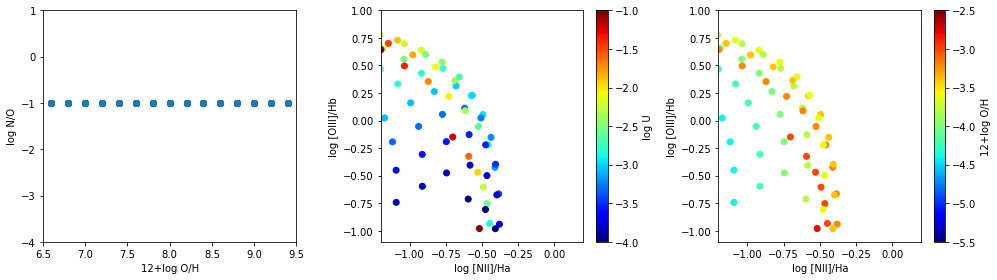

In [17]:
NOvOH_Cst = lambda x : x*0 -1.0
mask = ((np.abs(X_train[:,X_dic['NO']] - NOvOH_Cst(X_train[:,X_dic['O']]+12)) < 0.2) & 
        (X_train[:,X_dic['logU']] > -4.1) &
        (X_train[:,X_dic['logU']] < -.9) &
        (np.abs(X_train[:,X_dic['fr']] - 0.03) < 0.1) & 
        (np.abs(X_train[:,X_dic['age']] - 2) < 0.1) & 
        (X_train[:,X_dic['HbFrac']] > 0.95))
print('Number of models:',  mask.sum())

f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(14, 4))

ax0.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['NO']])
ax0.set_xlim((6.5, 9.5))
ax0.set_ylim((-4, 1))
ax0.set_xlabel('12+log O/H')
ax0.set_ylabel('log N/O')

sc1 = ax1.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], c=X_train[mask,2],vmin=-4, vmax=-1)
ax1.set_xlim((-1.2, 0.2))
ax1.set_ylim((-1.1, 1.))
ax1.set_xlabel('log [NII]/Ha')
ax1.set_ylabel('log [OIII]/Hb')
cb1 = f.colorbar(sc1, ax=ax1)
cb1.set_label('log U')

sc2 = ax2.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], c=X_train[mask,0],vmin=-5.5, vmax=-2.5)
ax2.set_xlim((-1.2, 0.2))
ax2.set_ylim((-1.1, 1.))
ax2.set_xlabel('log [NII]/Ha')
ax2.set_ylabel('log [OIII]/Hb')
cb2 = f.colorbar(sc2, ax=ax2)
cb2.set_label('12+log O/H')

f.tight_layout()
f.savefig('Figs/BPT_models')

Number of models: 183


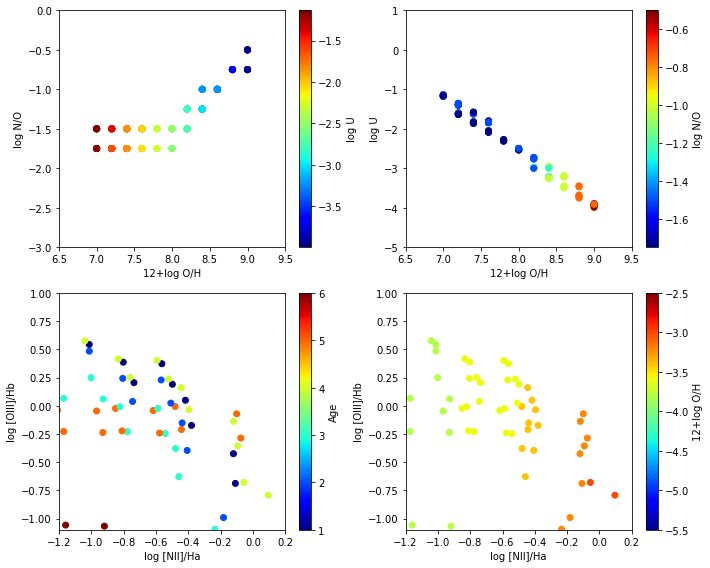

In [35]:
NOvOH_EPM14 = lambda x: np.where(x < 8., -1.6, 1. * x - 9.6)
logU_M16 = lambda OH: 8.42 - 1.37 * (12 + OH)

mask = ((np.abs(X_train[:,X_dic['NO']] - NOvOH_EPM14(X_train[:,X_dic['O']]+12)) < 0.2) & 
        (np.abs(X_train[:,X_dic['logU']] - logU_M16(X_train[:,X_dic['O']])) < 0.2)  &
        (np.abs(X_train[:,X_dic['fr']] - 0.03) < 0.1) & 
        (X_train[:,X_dic['HbFrac']] > 0.95))
print('Number of models:',  mask.sum())

f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(10, 8))

sc0 = ax0.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['NO']], c=X_train[mask,X_dic['logU']])
ax0.set_xlim((6.5, 9.5))
ax0.set_ylim((-3, 0))
ax0.set_xlabel('12+log O/H')
ax0.set_ylabel('log N/O')
cb0 = f.colorbar(sc0, ax=ax0)
cb0.set_label('log U')

sc1 = ax1.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['logU']], c=X_train[mask,X_dic['NO']])
ax1.set_xlim((6.5, 9.5))
ax1.set_ylim((-5, 1))
ax1.set_xlabel('12+log O/H')
ax1.set_ylabel('log U')
cb1 = f.colorbar(sc1, ax=ax1)
cb1.set_label('log N/O')

sc2 = ax2.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], c=X_train[mask,X_dic['age']],vmin=1, vmax=6)
ax2.set_xlim((-1.2, 0.2))
ax2.set_ylim((-1.1, 1.))
ax2.set_xlabel('log [NII]/Ha')
ax2.set_ylabel('log [OIII]/Hb')
cb2 = f.colorbar(sc2, ax=ax2)
cb2.set_label('Age')

sc3 = ax3.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], c=X_train[mask,0],vmin=-5.5, vmax=-2.5)
ax3.set_xlim((-1.2, 0.2))
ax3.set_ylim((-1.1, 1.))
ax3.set_xlabel('log [NII]/Ha')
ax3.set_ylabel('log [OIII]/Hb')
cb3 = f.colorbar(sc3, ax=ax3)
cb3.set_label('12+log O/H')

f.tight_layout()
f.savefig('Figs/BPT_models_0.03.png')

In [18]:
def plot_res(RM, NOvOH, logUvOH, fr=0.03, figfile=None):

    mask = ((np.abs(X_train[:,X_dic['NO']] - NOvOH(X_train[:,X_dic['O']]+12)) < 0.2) & 
            (np.abs(X_train[:,X_dic['logU']] - logUvOH(X_train[:,X_dic['O']] + 12 )) < 0.2)  &
            (np.abs(X_train[:,X_dic['fr']] - fr) < 0.1) & 
            (X_train[:,X_dic['HbFrac']] > 0.95))
    print('Number of models:',  mask.sum())

    tab_NO = NOvOH(tab_O + 12)
    tab_logU = logUvOH(tab_O + 12)

    tab_edad = np.random.randint(1, 6, len(tab_O))

    RM.set_test(np.array((tab_O, tab_NO, tab_logU, np.ones_like(tab_O) * 3.00, tab_edad, tab_Hbfrac)).T)
    RM.predict()

    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(10, 8))

    sc0 = ax0.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['NO']], 
                      c=X_train[mask,X_dic['logU']], marker='*', s=60)
    ax0.scatter(tab_O+12, tab_NO, marker='.', c=tab_logU)
    ax0.set_xlim((6.5, 9.5))
    ax0.set_ylim((-3, 1.5))
    rect = matplotlib.patches.Rectangle((6.6, -2), 2.8, 2, alpha=0.1)
    ax0.add_patch(rect)
    ax0.set_xlabel('12+log O/H')
    ax0.set_ylabel('log N/O')
    cb0 = f.colorbar(sc0, ax=ax0)
    cb0.set_label('log U')

    sc1 = ax1.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['logU']], 
                      c=X_train[mask,X_dic['NO']], marker='*', s=60)
    ax1.scatter(tab_O+12, tab_logU, marker='.', c=tab_NO)
    ax1.set_xlim((6.5, 9.5))
    ax1.set_ylim((-5, 1))
    rect = matplotlib.patches.Rectangle((6.6, -4), 2.8, 3, alpha=0.1)
    ax1.add_patch(rect)
    ax1.set_xlabel('12+log O/H')
    ax1.set_ylabel('log U')
    cb1 = f.colorbar(sc1, ax=ax1)
    cb1.set_label('log N/O')

    sc2 = ax2.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], 
                      c=X_train[mask,X_dic['age']],vmin=1, vmax=6, marker='*', s=60)
    ax2.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], 
                c=tab_edad, vmin=1, vmax=6, marker='.')
    ax2.set_xlim((-2., 0.5))
    ax2.set_ylim((-1.5, 1.2))
    ax2.set_xlabel('log [NII]/Ha')
    ax2.set_ylabel('log [OIII]/Hb')
    cb2 = f.colorbar(sc2, ax=ax2)
    cb2.set_label('Age')

    sc3 = ax3.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], 
                      c=X_train[mask,0],vmin=-5.5, vmax=-2.5, marker='*', s=60)
    ax3.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], c=tab_O, 
                vmin=-5.5, vmax=-2.5, marker='.')
    ax3.set_xlim((-2., 0.5))
    ax3.set_ylim((-1.5, 1.2))
    ax3.set_xlabel('log [NII]/Ha')
    ax3.set_ylabel('log [OIII]/Hb')
    cb3 = f.colorbar(sc3, ax=ax3)
    cb3.set_label('12+log O/H')

    f.tight_layout()
    if figfile is not None:
        f.savefig('Figs/{}'.format(figfile))

In [72]:
def plot_res3(RM, NOvOH, logUvOH, fr=0.03, figfile=None):

    mask = ((np.abs(X_train[:,X_dic['NO']] - NOvOH(X_train[:,X_dic['O']]+12)) < 0.2) & 
            (np.abs(X_train[:,X_dic['logU']] - logUvOH(X_train[:,X_dic['O']] + 12 )) < 0.2)  &
            (np.abs(X_train[:,X_dic['fr']] - fr) < 0.1) & 
            (X_train[:,X_dic['HbFrac']] > 0.95))
    print('Number of models:',  mask.sum())

    tab_NO = NOvOH(tab_O + 12)
    tab_logU = logUvOH(tab_O + 12)
    print('tabs defined')

    tab_edad = np.random.randint(1, 6, len(tab_O))
    print('tab_edad defined')

    RM.set_test(np.array((tab_O, tab_NO, tab_logU, np.ones_like(tab_O) * 3.00, tab_edad, tab_Hbfrac)).T)
    print('test set defined')
    RM.predict()
    print('Predictions done')
    
    f, ((ax0, ax1,ax2, ax3), (ax4, ax5,ax6, ax7)) = plt.subplots(2,4,figsize=(20, 8))

    sc0 = ax0.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['NO']], 
                      c=X_train[mask,X_dic['logU']], marker='*', s=60)
    ax0.scatter(tab_O+12, tab_NO, marker='.', c=tab_logU)
    ax0.set_xlim((6.5, 9.5))
    ax0.set_ylim((-3, 1.5))
    rect = matplotlib.patches.Rectangle((6.6, -2), 2.8, 2, alpha=0.1)
    ax0.add_patch(rect)
    ax0.set_xlabel('12+log O/H')
    ax0.set_ylabel('log N/O')
    cb0 = f.colorbar(sc0, ax=ax0)
    cb0.set_label('log U')

    sc1 = ax1.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['logU']], 
                      c=X_train[mask,X_dic['NO']], marker='*', s=60)
    ax1.scatter(tab_O+12, tab_logU, marker='.', c=tab_NO)
    ax1.set_xlim((6.5, 9.5))
    ax1.set_ylim((-5, 1))
    rect = matplotlib.patches.Rectangle((6.6, -4), 2.8, 3, alpha=0.1)
    ax1.add_patch(rect)
    ax1.set_xlabel('12+log O/H')
    ax1.set_ylabel('log U')
    cb1 = f.colorbar(sc1, ax=ax1)
    cb1.set_label('log N/O')

    sc2 = ax2.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], 
                      c=X_train[mask,X_dic['age']],vmin=1, vmax=6, marker='*', s=60)
    ax2.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], 
                c=tab_edad, vmin=1, vmax=6, marker='.')
    ax2.set_xlim((-2., 0.5))
    ax2.set_ylim((-1.5, 1.2))
    ax2.set_xlabel('log [NII]/Ha')
    ax2.set_ylabel('log [OIII]/Hb')
    cb2 = f.colorbar(sc2, ax=ax2)
    cb2.set_label('Age [Myr')

    sc3 = ax3.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], 
                      c=X_train[mask,0],vmin=-5.5, vmax=-2.5, marker='*', s=60)
    ax3.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], c=tab_O, 
                vmin=-5.5, vmax=-2.5, marker='.')
    ax3.set_xlim((-2., 0.5))
    ax3.set_ylim((-1.5, 1.2))
    ax3.set_xlabel('log [NII]/Ha')
    ax3.set_ylabel('log [OIII]/Hb')
    cb3 = f.colorbar(sc3, ax=ax3)
    cb3.set_label('12+log O/H')


    sc4 = ax4.scatter(RM.pred[:,y_dic['N2']], tab_O+12, c=RM.X_test_unscaled[:,X_dic['age']], marker='.')
    ax4.set_xlabel('N2')
    ax4.set_ylabel('12+log O/H')
    ax4.set_xlim((-3, 0))
    ax4.set_ylim((6.5, 9.5))
    cb4 = f.colorbar(sc4, ax=ax4)
    cb4.set_label('Age [Myr')

    sc5 = ax5.scatter(RM.pred[:,y_dic['O3']]-RM.pred[:,y_dic['N2']], tab_O+12, c=RM.X_test_unscaled[:,X_dic['age']], marker='.')
    ax5.set_xlabel('O3N2')
    ax5.set_ylabel('12+log O/H')
    ax5.set_xlim((-2, 4))
    ax5.set_ylim((6.5, 9.5))
    cb5 = f.colorbar(sc5, ax=ax5)
    cb5.set_label('Age [Myr')
    
    sc6 = ax6.scatter(np.log10(10**RM.pred[:,y_dic['O2']] + 10**RM.pred[:,y_dic['O3']]), tab_O+12, c=RM.X_test_unscaled[:,X_dic['age']], marker='.')
    ax6.set_xlabel('R23')
    ax6.set_ylabel('12+log O/H')
    ax6.set_xlim((-1, 1))
    ax6.set_ylim((6.5, 9.5))
    cb6 = f.colorbar(sc6, ax=ax6)
    cb6.set_label('Age [Myr]')
    
    sc7 = ax7.scatter(RM.pred[:,y_dic['N2']]-RM.pred[:,y_dic['O2']], tab_NO, c=RM.X_test_unscaled[:,X_dic['age']], marker='.')
    ax7.set_xlabel('N2O2')
    ax7.set_ylabel('log N/O')
    ax7.set_xlim((-2, 1))
    ax7.set_ylim((-2, 0))
    cb7 = f.colorbar(sc7, ax=ax7)
    cb7.set_label('Age [Myr]')
        
    f.tight_layout()
    if figfile is not None:
        f.savefig('Figs/{}'.format(figfile))

Number of models: 183
tabs defined
tab_edad defined
test set defined
Predictions done


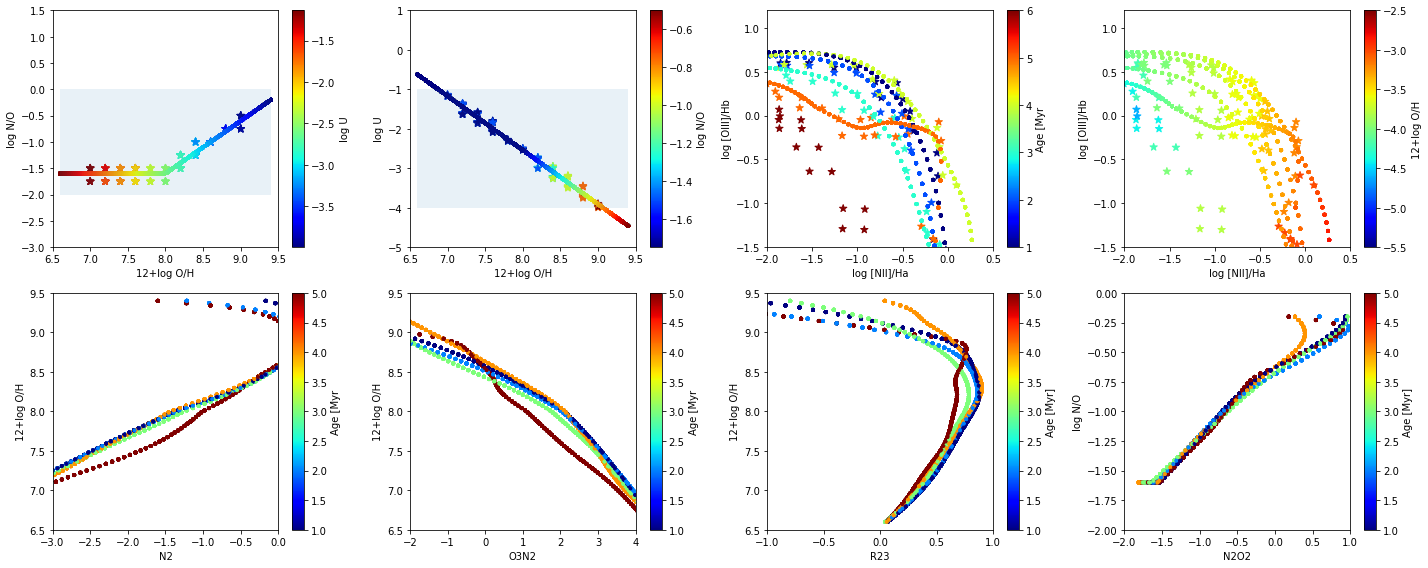

In [73]:
plot_res3(RM_ANN, 
         NOvOH=lambda x: np.where(x < 8., -1.6, 1. * x - 9.6), #EPM14
         logUvOH = lambda OH: 8.42 - 1.37 * (OH), #M16
         fr=0.03, 
         figfile='FIG1b.png')

Number of models: 165
tabs defined
tab_edad defined
test set defined
Predictions done


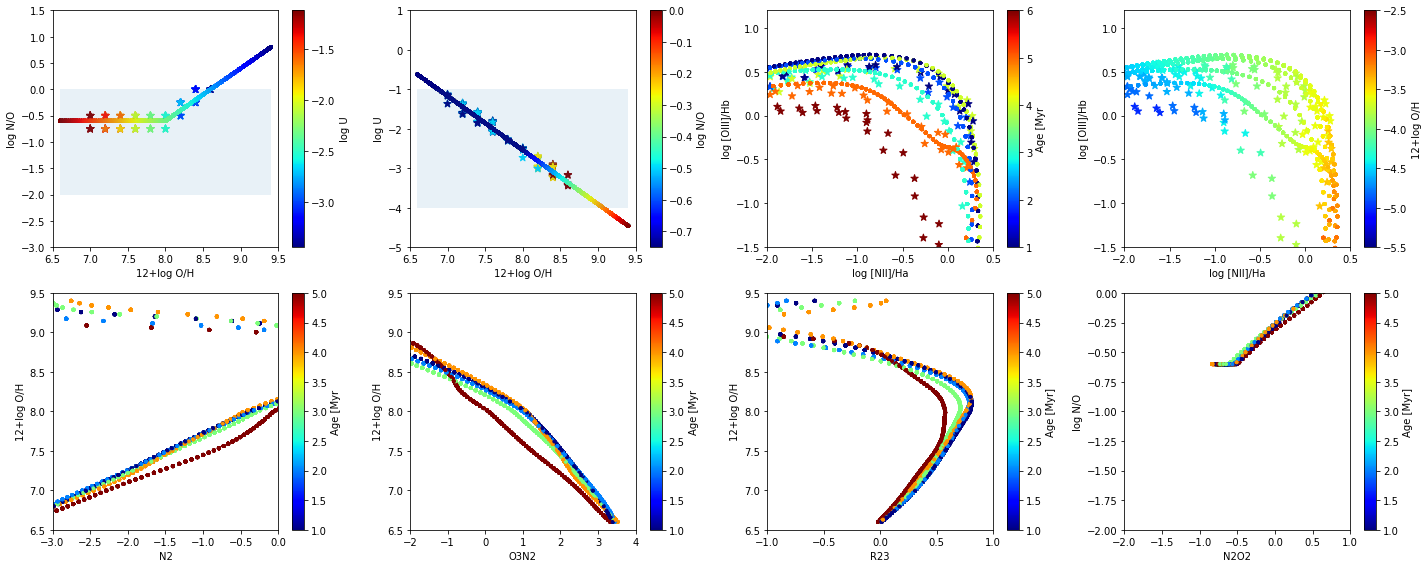

In [74]:
plot_res3(RM_ANN, 
         NOvOH=lambda x: np.where(x < 8., -1.6+1, 1. * x - 9.6+1), #EPM14
         logUvOH = lambda OH: 8.42 - 1.37 * (OH), #M16
         fr=0.03, 
         figfile='FIG2b.png')

Number of models: 183
tabs defined
tab_edad defined
test set defined
Predictions done


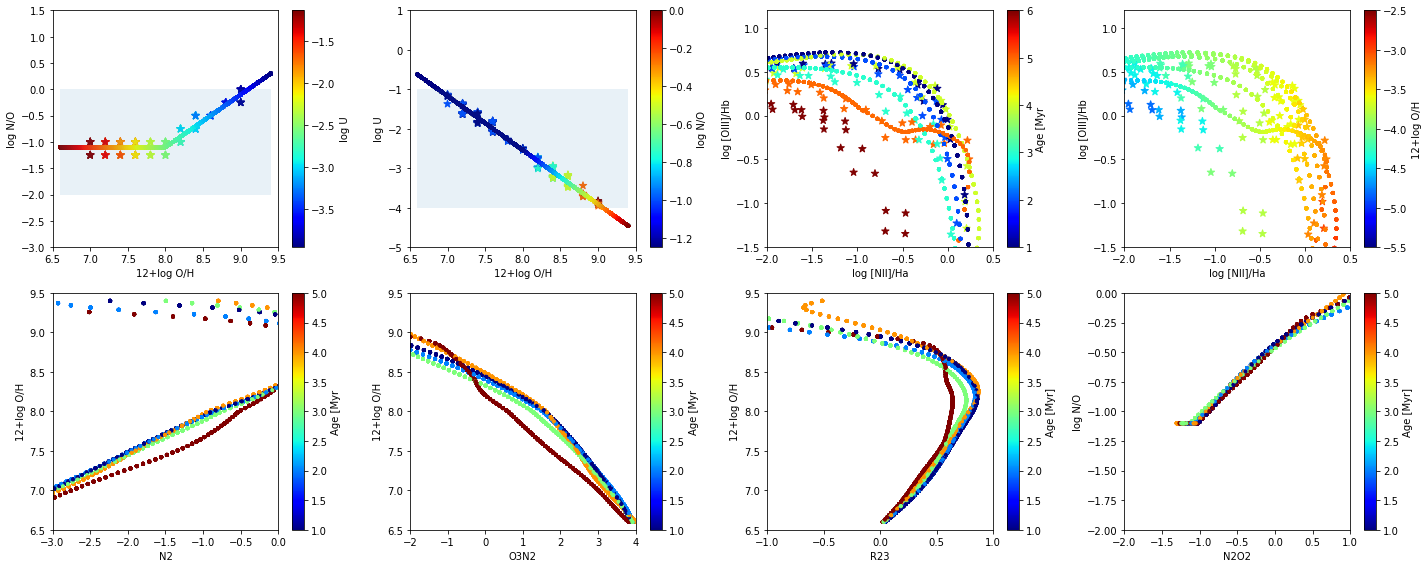

In [75]:
plot_res3(RM_ANN, 
         NOvOH=lambda x: np.where(x < 8., -1.6+0.5, 1. * x - 9.6+0.5), #EPM14
         logUvOH = lambda OH: 8.42 - 1.37 * (OH), #M16
         fr=0.03, 
         figfile='FIG3b.png')

Number of models: 87
tabs defined
tab_edad defined
test set defined
Predictions done


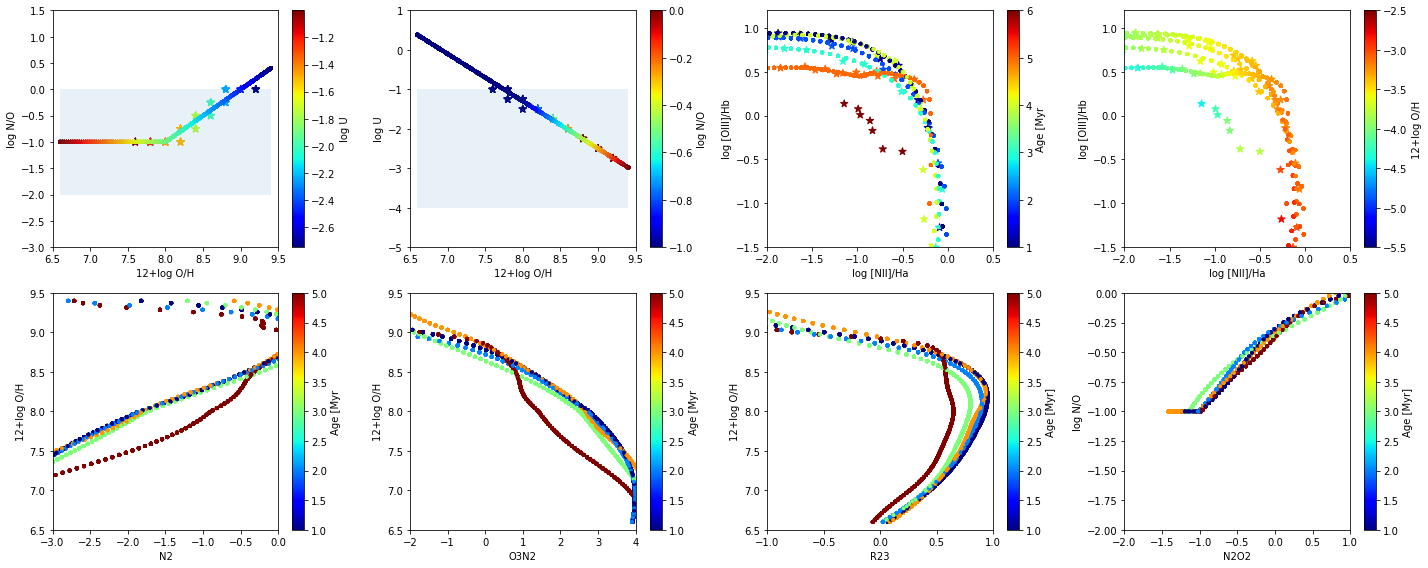

In [76]:
plot_res3(RM_ANN, 
         NOvOH=lambda x: np.where(x < 8., -1., 1. * x - 9.), #EPM14
         logUvOH = lambda OH: 8.3 - 1.2 * (OH), 
         fr=3.00, 
         figfile='FIG4b.png')

Number of models: 162
tabs defined
tab_edad defined
test set defined
Predictions done


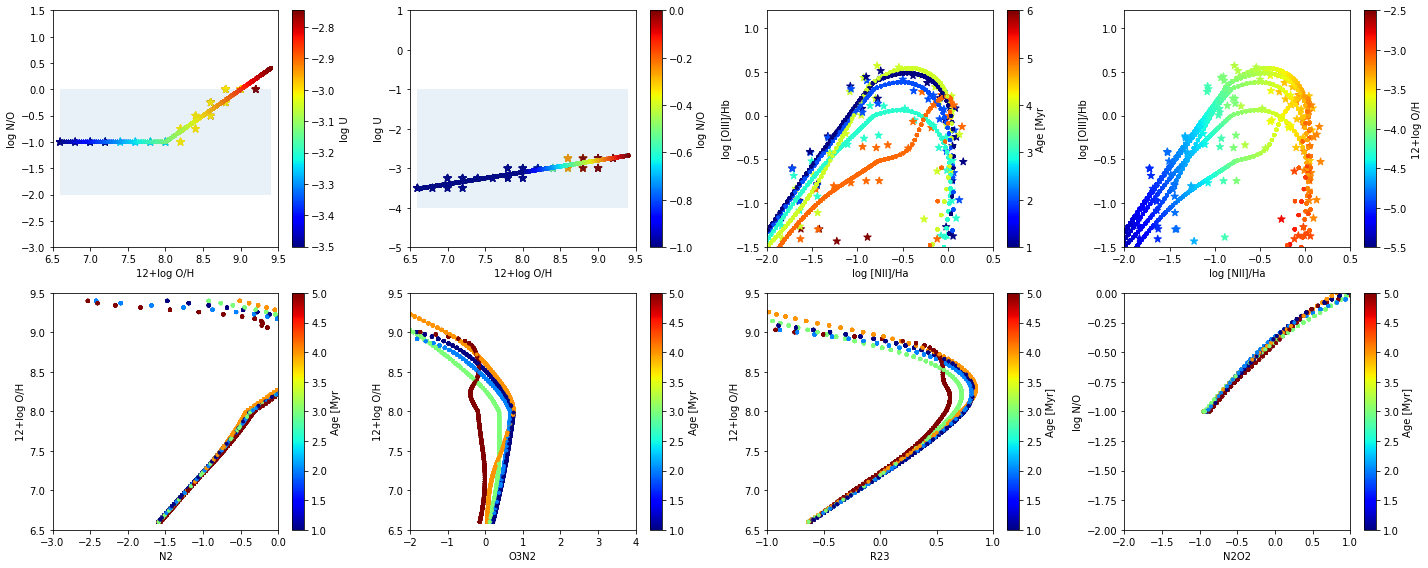

In [77]:
plot_res3(RM_ANN, 
         NOvOH=lambda x: np.where(x < 8., -1., 1. * x - 9.), #EPM14
         logUvOH = lambda OH: -5.5 + .3 * (OH), 
         fr=3.00, 
         figfile='FIG5b.png')

Number of models: 0


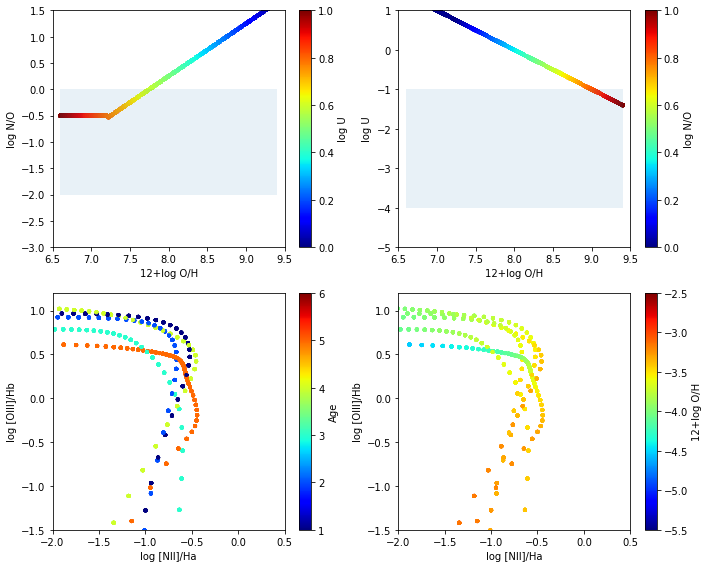

In [27]:
plot_res(RM_ANN, 
         NOvOH=lambda x: np.where(x < 7.2, -0.5, 1. * x - 7.75), # Carlos
         logUvOH = lambda OH: 8.0 - 1. * (OH), #Carlos
         fr=0.03, 
         figfile=None)

Number of models: 216
Test data scaled. 
Training set size = 42120, Test set size = 10000
Predicting from 6 inputs to 8 outputs using 10000 data in 175.87 secs.


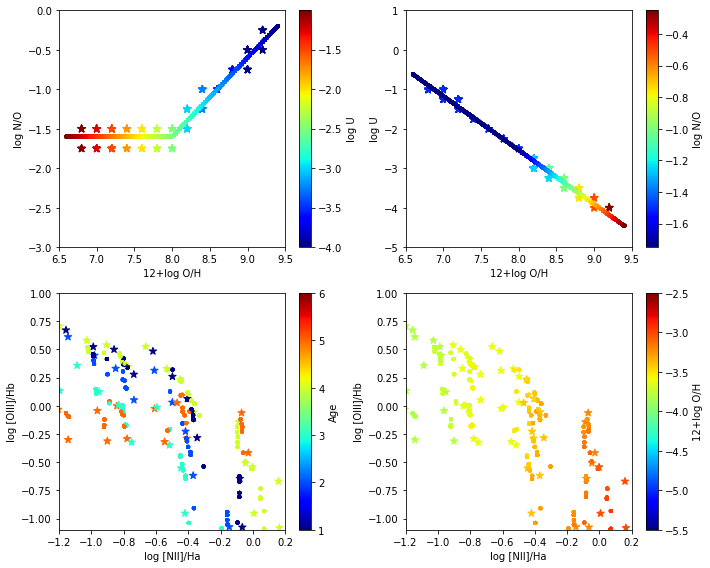

In [74]:
NOvOH_EPM14 = lambda x: np.where(x < 8., -1.6, 1. * x - 9.6)
logU_M16 = lambda OH: 8.42 - 1.37 * (OH)

mask = ((np.abs(X_train[:,X_dic['NO']] - NOvOH_EPM14(X_train[:,X_dic['O']]+12)) < 0.2) & 
        (np.abs(X_train[:,X_dic['logU']] - logU_M16(X_train[:,X_dic['O']] + 12 )) < 0.2)  &
        (np.abs(X_train[:,X_dic['fr']] - 3.0) < 0.1) & 
        (X_train[:,X_dic['HbFrac']] > 0.95))
print('Number of models:',  mask.sum())

tab_NO = NOvOH_EPM14(tab_O + 12)
tab_logU = logU_M16(tab_O + 12)

RM = RM_XGB
tab_edad = np.random.randint(1, 6, len(tab_O))

RM.set_test(np.array((tab_O, tab_NO, tab_logU, np.ones_like(tab_O) * 3.00, tab_edad, tab_Hbfrac)).T)
RM.predict()

f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(10, 8))

sc0 = ax0.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['NO']], 
                  c=X_train[mask,X_dic['logU']], marker='*', s=60)
ax0.scatter(tab_O+12, tab_NO, marker='.', c=tab_logU)
ax0.set_xlim((6.5, 9.5))
ax0.set_ylim((-3, 0))
ax0.set_xlabel('12+log O/H')
ax0.set_ylabel('log N/O')
cb0 = f.colorbar(sc0, ax=ax0)
cb0.set_label('log U')
6461935817
sc1 = ax1.scatter(X_train[mask,X_dic['O']]+12, X_train[mask,X_dic['logU']], 
                  c=X_train[mask,X_dic['NO']], marker='*', s=60)
ax1.scatter(tab_O+12, tab_logU, marker='.', c=tab_NO)
ax1.set_xlim((6.5, 9.5))
ax1.set_ylim((-5, 1))
ax1.set_xlabel('12+log O/H')
ax1.set_ylabel('log U')
cb1 = f.colorbar(sc1, ax=ax1)
cb1.set_label('log N/O')

sc2 = ax2.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], 
                  c=X_train[mask,X_dic['age']],vmin=1, vmax=6, marker='*', s=60)
ax2.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], 
            c=tab_edad, vmin=1, vmax=6, marker='.')
ax2.set_xlim((-1.2, 0.2))
ax2.set_ylim((-1.1, 1.))
ax2.set_xlabel('log [NII]/Ha')
ax2.set_ylabel('log [OIII]/Hb')
cb2 = f.colorbar(sc2, ax=ax2)
cb2.set_label('Age')

sc3 = ax3.scatter(y_train[mask,y_dic['N2']]-np.log10(2.8), y_train[mask,y_dic['O3']], 
                  c=X_train[mask,0],vmin=-5.5, vmax=-2.5, marker='*', s=60)
ax3.scatter(RM.pred[:,y_dic['N2']]-np.log10(2.8), RM.pred[:,y_dic['O3']], c=tab_O, 
            vmin=-5.5, vmax=-2.5, marker='.')
ax3.set_xlim((-1.2, 0.2))
ax3.set_ylim((-1.1, 1.))
ax3.set_xlabel('log [NII]/Ha')
ax3.set_ylabel('log [OIII]/Hb')
cb3 = f.colorbar(sc3, ax=ax3)
cb3.set_label('12+log O/H')

f.tight_layout()
f.savefig('Figs/BPT_modelsXGB_3.0.png')

## Plot the results

Test data scaled. 
Training set size = 42120, Test set size = 10000
Predicting from 6 inputs to 8 outputs using 10000 data in 0.21 secs.


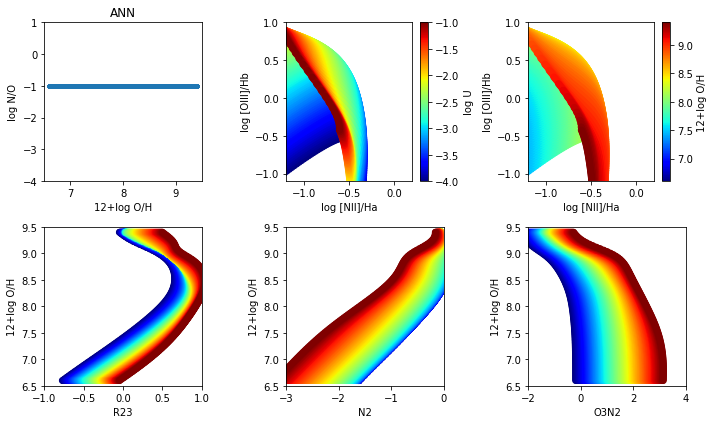

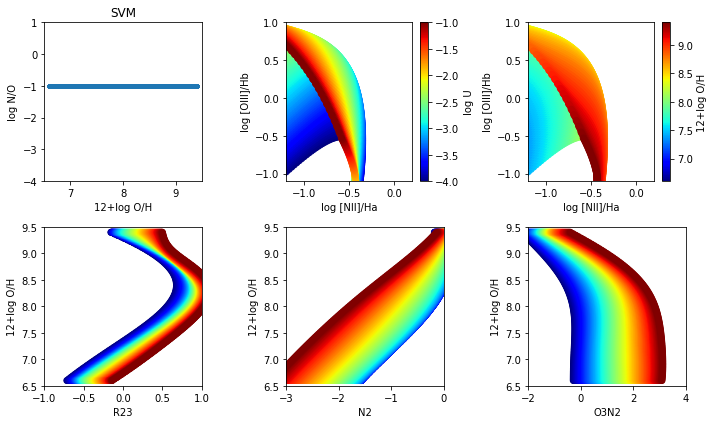

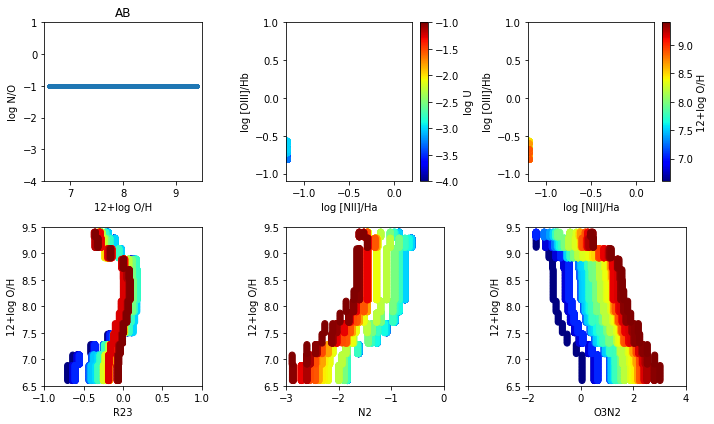

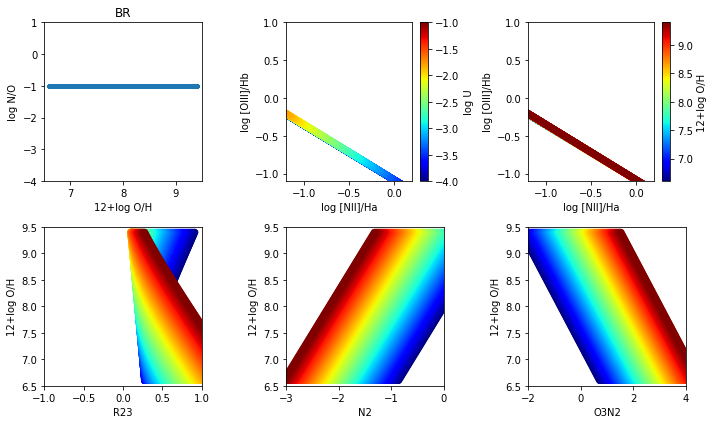

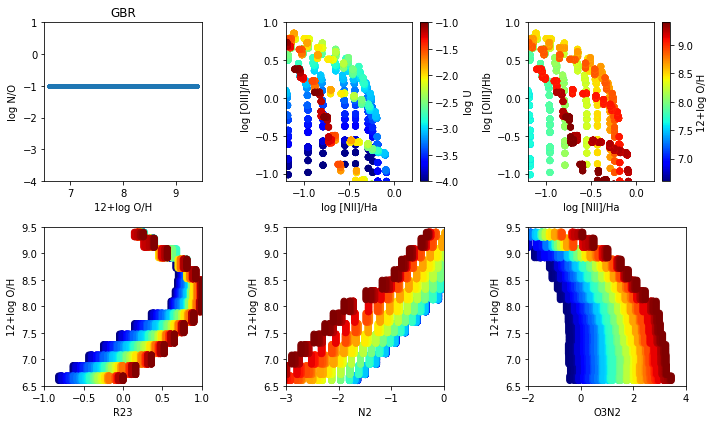

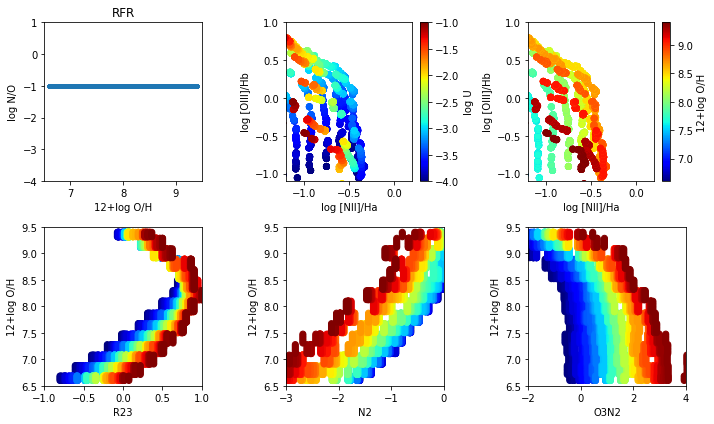

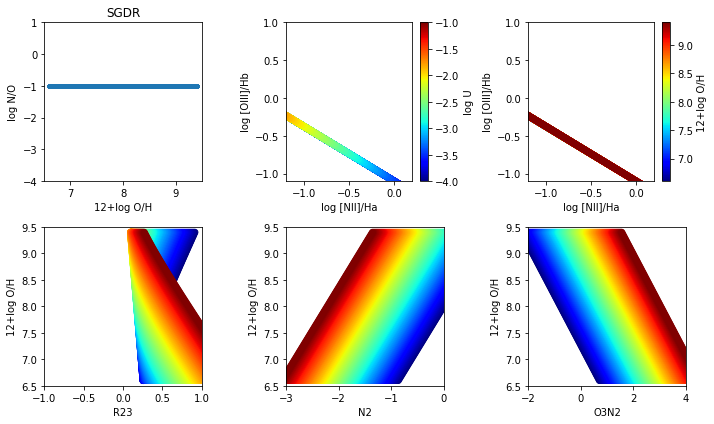

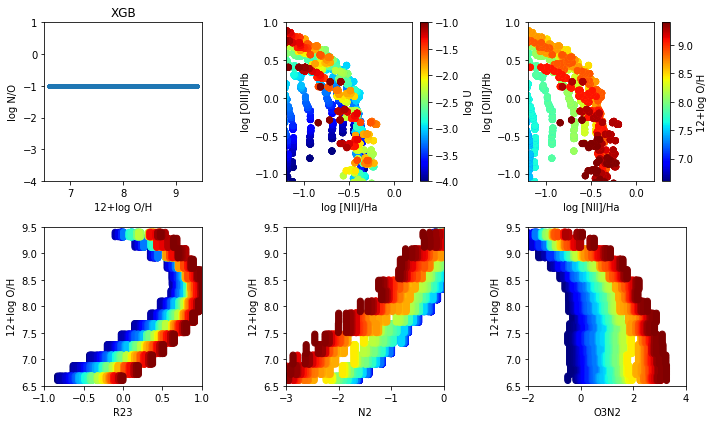

In [47]:
# log N/O vs. 12+log O/H laws:
NOvOH_Cst = lambda x : x*0 -1.0
tab_NO = NOvOH_Cst(tab_O+12)
plot_res1(RM_ANN, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_ANN')
plot_res1(RM_SVM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_SVM')
plot_res1(RM_AB, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_AB')
plot_res1(RM_BR, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_BR')
plot_res1(RM_GBR, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_GBR')
#plot_res1(RM_GPR, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_GPR')
plot_res1(RM_RFR, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_RFR')
plot_res1(RM_SGDR, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_SGDR')
#plot_res1(RM_XGB, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst_XGB')

In [58]:
RM = RM_SVM

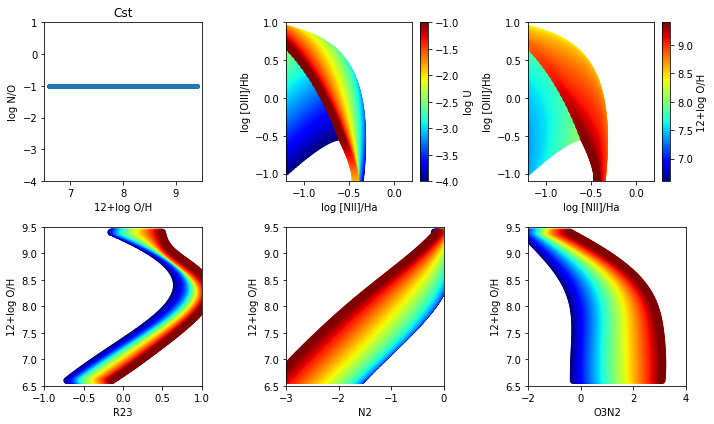

In [59]:
# log N/O vs. 12+log O/H laws:
NOvOH_Cst = lambda x : x*0 -1.0
tab_NO = NOvOH_Cst(tab_O+12)
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_Cst')

## Change the N/O vs. O/H law, predict the models, and plot the result

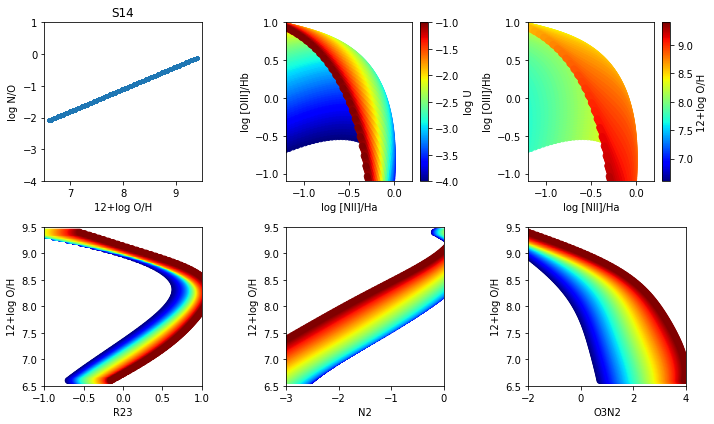

In [18]:
NOvOH_S14 = lambda x : 0.7 * (x - 8) - 1.1
tab_NO = NOvOH_S14(tab_O+12)
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_S14')

Test data scaled. 
Training set size = 42120, Test set size = 10000
Predicting from 6 inputs to 8 outputs using 10000 data in 4.19 secs.


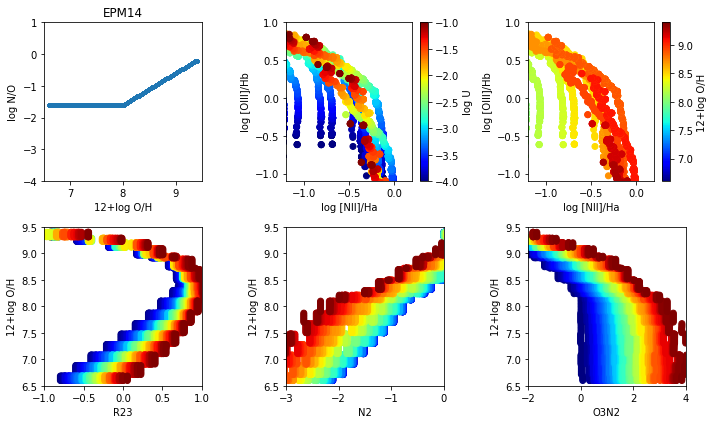

In [15]:
NOvOH_EPM14 = lambda x: np.where(x < 8., -1.6, 1. * x - 9.6)
tab_NO = NOvOH_EPM14(tab_O+12)
plot_res1(RM_XGB, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_EPM14')

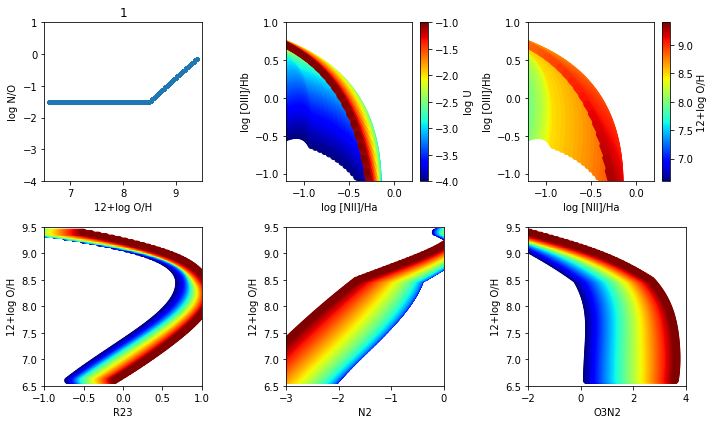

In [20]:
NOvOH_1 = lambda x: np.where(x < 8.5, -1.5, 1.5 * x - 14.25)
tab_NO = NOvOH_1(tab_O+12)
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_1')

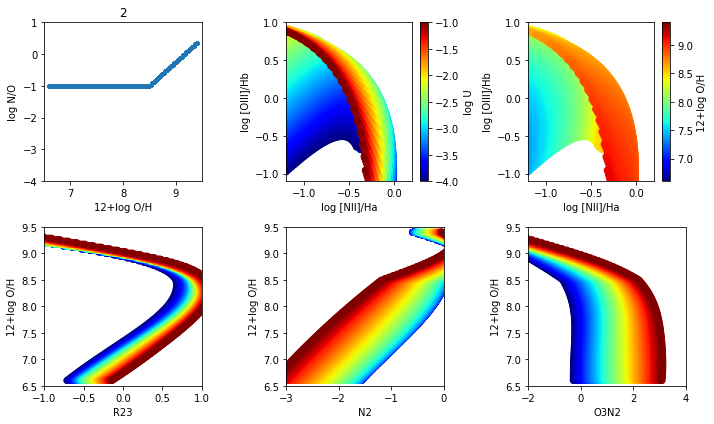

In [21]:
NOvOH_2 = lambda x: np.where(x < 8.5, -1., 1.5 * x - 13.75)
tab_NO = NOvOH_2(tab_O+12)
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_2')

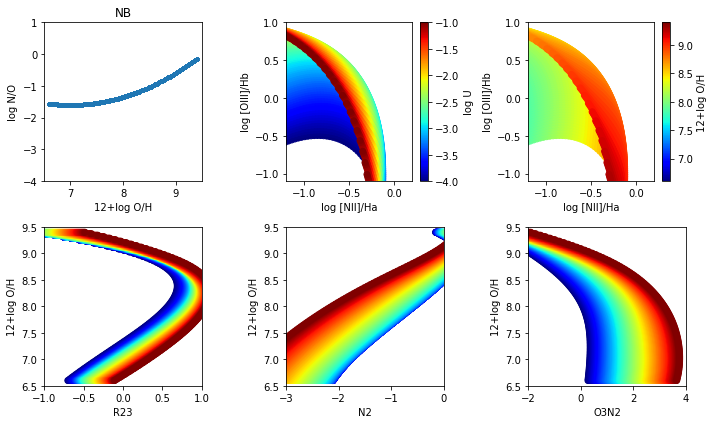

In [22]:
NOvOH_NB = lambda x: 0.25*(x - 7)**2 - 1.6

tab_NO = NOvOH_NB(tab_O+12)
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_NB')

## Effect of the burst age

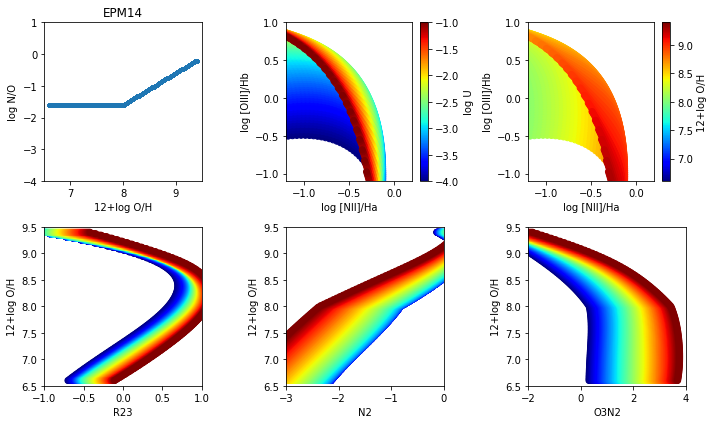

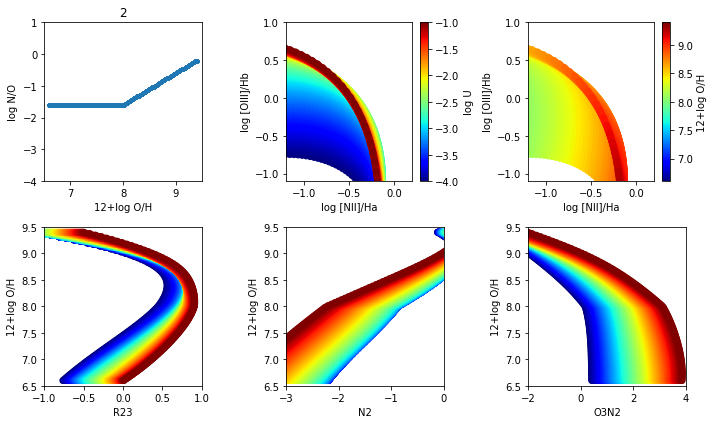

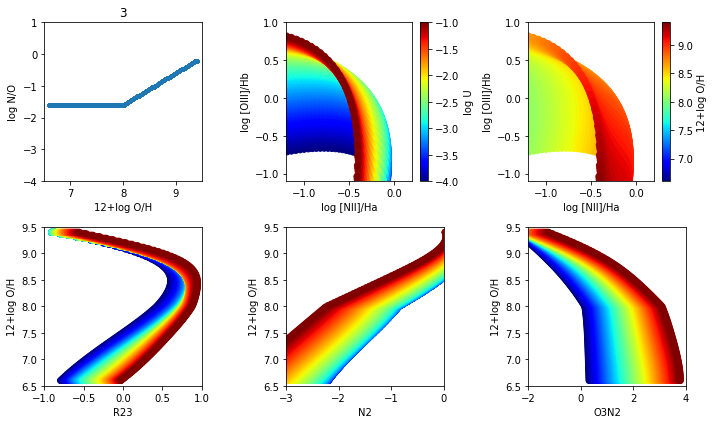

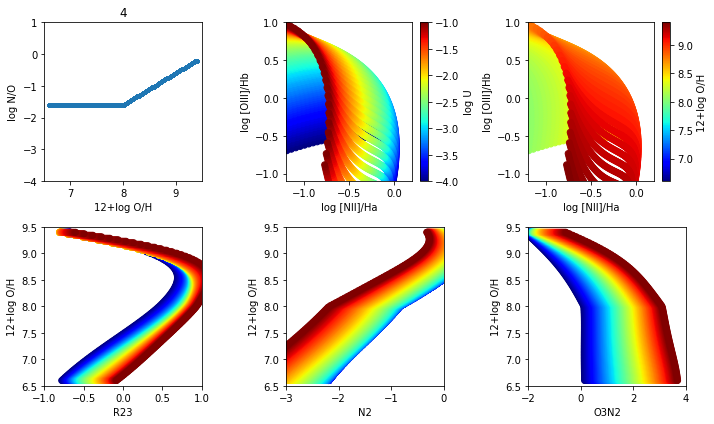

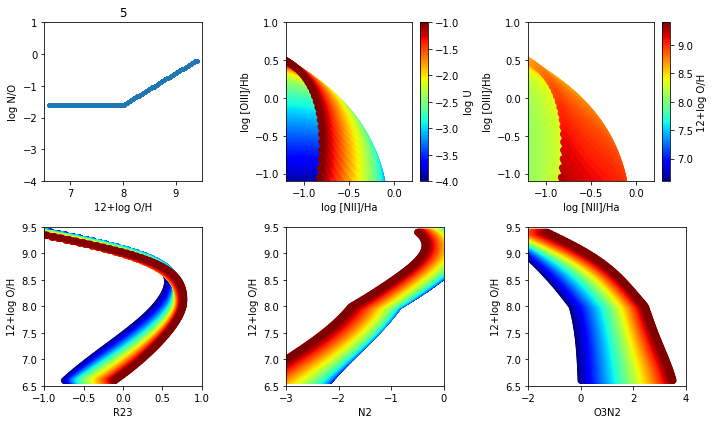

In [23]:
NOvOH_EPM14 = lambda x: np.where(x < 8., -1.6, 1. * x - 9.6)
tab_NO = NOvOH_EPM14(tab_O+12)
tab_edad = np.ones_like(tab_O) * 1
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_EPM14')
tab_edad = np.ones_like(tab_O) * 2
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_EPM14_2')
tab_edad = np.ones_like(tab_O) * 3
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_EPM14_3')
tab_edad = np.ones_like(tab_O) * 4
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_EPM14_4')
tab_edad = np.ones_like(tab_O) * 5
plot_res1(RM, tab_O, tab_NO, tab_logU, tab_fr, tab_edad, tab_Hbfrac, filename='BPT_NO_EPM14_5')